<a href="https://colab.research.google.com/github/ks-chauhan/machine-Degradation/blob/main/RUL_Prediction_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This Notebook will serve as the prototype demonstration for the potential solution for the problem of Antenna Health Monitoring. The demonstration will be done by solving a simillar problem based on a Dataset provided by Nasa on the Turbofan Engines Degradation time span.

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import xgboost as xgb

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
np.random.seed(18)

In [ ]:
train_data=pd.read_csv("train_FD001.txt", sep="\s+", header=None,engine='python')

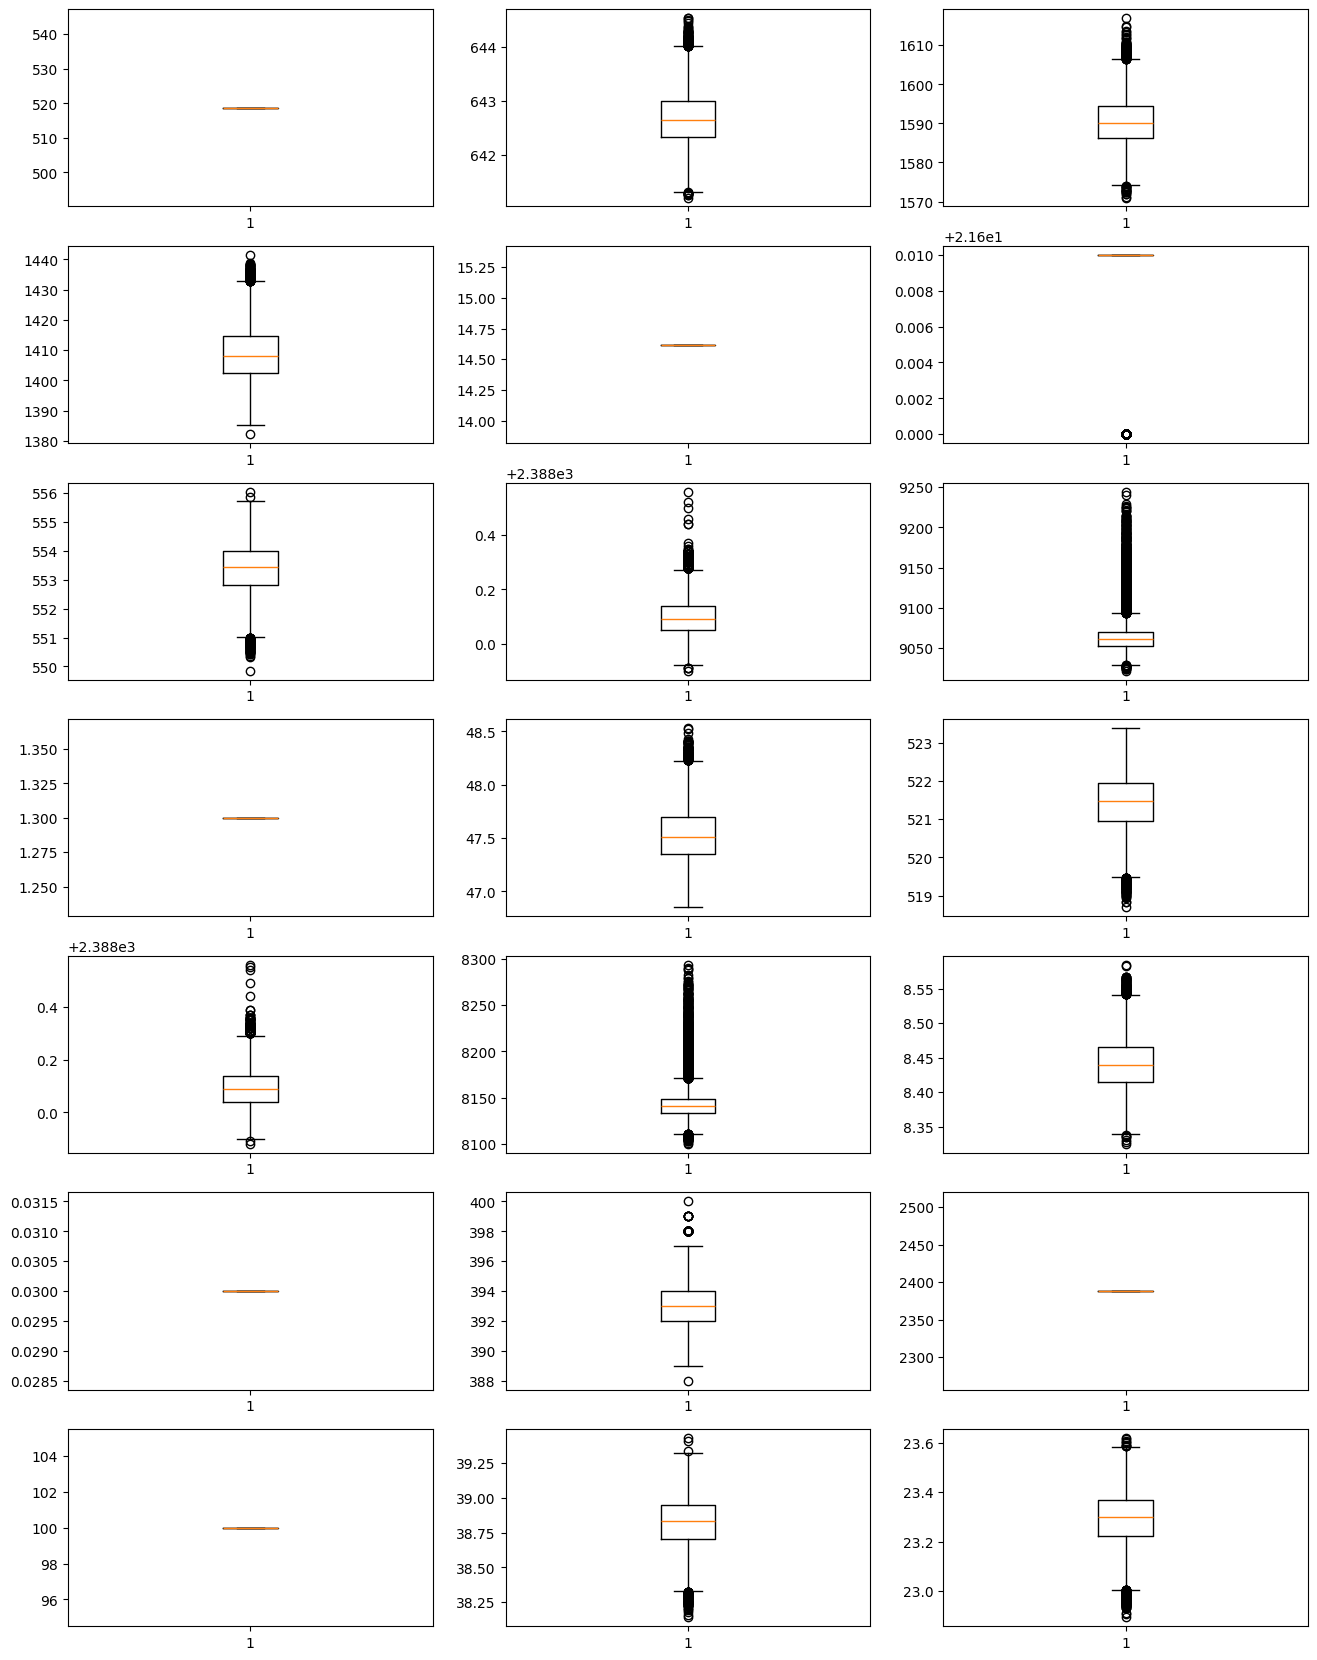

In [ ]:
plt.figure(figsize=(16,21))
for i in range(21):
  temp_data=train_data.iloc[:,i+5]
  plt.subplot(7,3,i+1)
  plt.boxplot(temp_data)
plt.show()

In [ ]:
def process_targets(data_length, early_rul = None):
  """
  based on input data length and early degradation occurance target rul is the output
  """
  if early_rul == None:
    return np.arange(data_length-1, -1, -1)
  else:
    safe_duration=data_length-early_rul
    if(safe_duration<=0):
      return np.arange(data_length-1, -1, -1)
    else:
      return np.append(safe_duration*np.ones(shape=(safe_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data,target_data=None,window_length=1,shift=1):
  """
  Depending on values of window length and shift, this function will generate batches of the data and targets
  based on input data and target data provided.

  Args :
    input_data: 2 dimensional input data
    target_data: 1 dimensional input rul values
    window_length: window length of data
    shift : Distance by which the window moves for next batch. This is closely related to overlap
            between data. For example, if window length is 30 and shift is 1, there is an overlap of
            29 data points between two consecutive batches. Adds Sequential Context.
  """
  num_batches = int(np.floor((len(input_data)-window_length)/shift)+1)
  num_features = input_data.shape[1]
  output_data = np.repeat(np.nan, num_batches*window_length*num_features).reshape(num_batches, window_length, num_features)

  if target_data is None:
    for batch in range(num_batches):
      output_data[batch,:,:] = input_data[(0+batch*shift):(0+batch*shift+window_length),:]
    return output_data
  else:
    output_targets=np.repeat(np.nan, num_batches)
    for batch in range(num_batches):
      output_data[batch,:,:] = input_data[(0+batch*shift):(0+batch*shift+window_length),:]
      output_targets[batch] = target_data[(batch*shift)+(window_length-1)]
    return output_data, output_targets


In [ ]:
def process_test_data(input_data, num_test_windows=1, window_length=1, shift=1):
  """
  The function return last examples and number of last examples (a scaler) as output.
  We need the second output later. If we are extracting more than 1 last examples, we have to
  average their prediction results. The second scaler halps us do just that.
  args:
    input_data: input data
    num_test_windows: number of test windows to take from each engine (from last) we do this because
                      we don't have to look at all time stamps for a machine in test data.
    window_length: window length of data that is going to move in test data
    shape: shape of the output data

  """
  max_num_test_batches=int(np.floor((len(input_data)-window_length)/shift))+1
  if(num_test_windows>max_num_test_batches):
    required_len=(max_num_test_batches-1)*shift+window_length
    batched_test_data = process_input_data_with_targets(input_data=input_data[-required_len:, :],
                                                        target_data=None,
                                                        window_length=window_length,
                                                        shift=shift)
    return batched_test_data, max_num_test_batches
  else:
    required_len=(num_test_windows-1)*shift+window_length
    batched_test_data = process_input_data_with_targets(input_data=input_data[-required_len:, :],
                                                        target_data=None,
                                                        window_length=window_length,
                                                        shift=shift)
    return batched_test_data, num_test_windows


In [ ]:
test_data=pd.read_csv("test_FD001.txt", sep="\s+", header=None, engine='python')
rul_data=pd.read_csv("RUL_FD001.txt", sep="\s+", header=None, engine='python')
window_length=30
shift=1
early_rul=125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window
# of test data for each engine are taken. If set to a different number, that many windows from last are taken.
# Final output is the average of output of all windows.

num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

## dropping columns that remain constant
columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

## Scale Data for all engines
Scaler=StandardScaler()
train_data = Scaler.fit_transform(train_data.drop(columns=columns_to_be_dropped))
test_data = Scaler.transform(test_data.drop(columns=columns_to_be_dropped))

train_data=pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data=pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process training data
for i in np.arange(1, num_train_machines+1):
  temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

  # Verify if data of given window length can be extracted from training data
  if (len(temp_train_data) < window_length):
    print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
    raise AssertionError("Window length is larger than number of data points for some engines. "
                         "Try decreasing window length.")

  temp_train_targets=process_targets(data_length=len(temp_train_data), early_rul=early_rul)
  data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, window_length = window_length, shift = shift)

  processed_train_data.append(data_for_a_machine)
  processed_train_targets.append(targets_for_a_machine)
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
  temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

  # Verify if data of given window length can be extracted from test data
  if (len(temp_test_data) < window_length):
      print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
      raise AssertionError("Window length is larger than number of data points for some engines. "
                            "Try decreasing window length.")

  # Prepare test data
  test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                          num_test_windows = num_test_windows)

  processed_test_data.append(test_data_for_an_engine)
  num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = rul_data[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", rul_data.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100, 1)


## Training and Validation Split
We work with 80-20 split for training data and validation data.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (11347, 30, 14)
Processed validation data shape:  (2837, 30, 14)
Processed train targets shape:  (11347,)
Processed validation targets shape:  (2837,)
